In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.dataset import EnhancementDataset


In [2]:
from src.model.attention import MultiHeadAttention


In [3]:
from src.model.patch_embedding import PatchEmbedding
from src.model.transformer import TransformerEncoder
from src.model.image_enhance_transformer import ImageEnhanceTransformer

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [5]:
dataset = EnhancementDataset('data/train/low_res', 'data/train/high_res', transform=transform)


In [6]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [7]:
def create_test_image(size=(224, 224)):
    # Create a simple test image (checkerboard pattern)
    image = torch.zeros((1, 3, size[0], size[1]))
    for i in range(0, size[0], 16):
        for j in range(0, size[1], 16):
            if (i // 16 + j // 16) % 2 == 0:
                image[0, :, i:i+16, j:j+16] = 1
    return image

test_image = create_test_image()

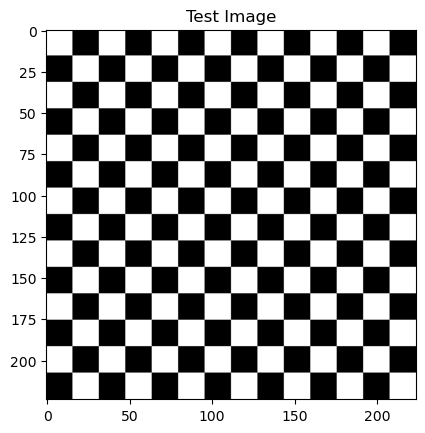

In [8]:
plt.imshow(test_image.squeeze().permute(1, 2, 0))
plt.title("Test Image")
plt.show()

In [9]:
patch_embed = PatchEmbedding(image_size=(224, 224), patch_size=16, embed_dim=128)

In [10]:
with torch.no_grad():
    embedded_patches = patch_embed(test_image)

print("Embedded patches shape:", embedded_patches.shape)

Embedded patches shape: torch.Size([1, 196, 128])


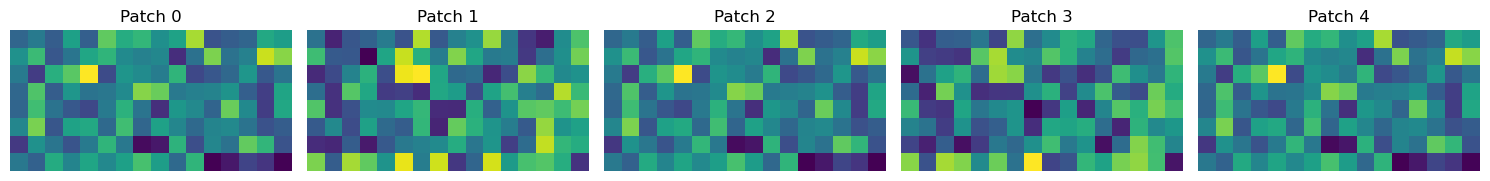

In [11]:
def visualize_embeddings(embedded_patches, num_patches=5):
    fig, axes = plt.subplots(1, num_patches, figsize=(15, 3))
    for i in range(num_patches):
        axes[i].imshow(embedded_patches[0, i].reshape(8, 16).detach().numpy(), cmap='viridis')
        axes[i].set_title(f"Patch {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_embeddings(embedded_patches)

Positional embedding shape: torch.Size([1, 196, 128])


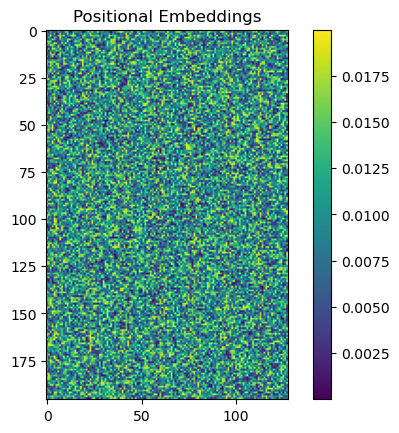

In [12]:
print("Positional embedding shape:", patch_embed.pos_embed.shape)
plt.imshow(patch_embed.pos_embed.squeeze().detach().numpy(), cmap='viridis')
plt.title("Positional Embeddings")
plt.colorbar()
plt.show()

In [13]:
# Now let's create a test
def test_multi_head_attention():
    # Set up parameters
    batch_size = 32
    num_patches = 196  # e.g., 14x14 patches for a 224x224 image with 16x16 patches
    embed_dim = 768
    num_heads = 12

    # Create an instance of MultiHeadAttention
    mha = MultiHeadAttention(embed_dim, num_heads)

    # Create a dummy input tensor
    x = torch.randn(batch_size, num_patches, embed_dim)

    # Run the input through the attention mechanism
    output = mha(x)

    # Check output shape
    assert output.shape == x.shape, f"Output shape {output.shape} does not match input shape {x.shape}"

    print("Input shape:", x.shape)
    print("Output shape:", output.shape)
    print("Test passed successfully!")

# Run the test
test_multi_head_attention()


Input shape: torch.Size([32, 196, 768])
Output shape: torch.Size([32, 196, 768])
Test passed successfully!


Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 3, 224, 224])
Test passed successfully!


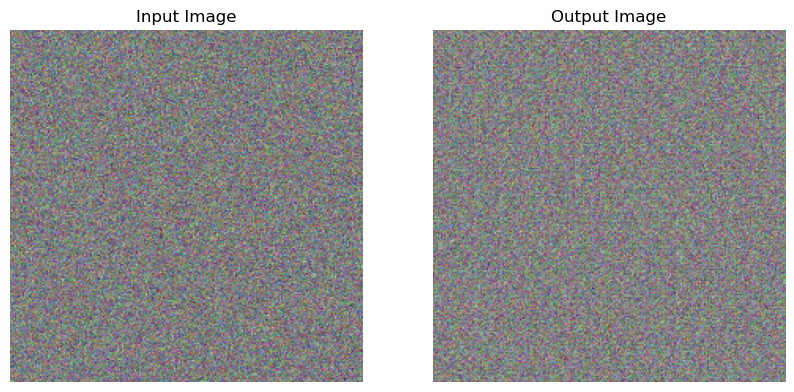

In [14]:
# Define model parameters
image_size = (224, 224)
patch_size = 16
embed_dim = 768
num_layers = 6
num_heads = 8
output_size = (224, 224)  # Same as input for this test
in_channels = 3

# Create model instance
model = ImageEnhanceTransformer(image_size, patch_size, embed_dim, num_layers, num_heads, output_size, in_channels)

# Create a random input tensor
batch_size = 4
input_tensor = torch.randn(batch_size, in_channels, image_size[0], image_size[1])

# Pass input through the model
output = model(input_tensor)

# Print input and output shapes
print(f"Input shape: {input_tensor.shape}")
print(f"Output shape: {output.shape}")

# Check if output shape matches the expected shape
assert output.shape == (batch_size, in_channels, output_size[0], output_size[1]), \
    f"Output shape {output.shape} doesn't match expected shape {(batch_size, in_channels, output_size[0], output_size[1])}"

print("Test passed successfully!")

# Optionally, visualize a sample input and output
def visualize_sample(input_tensor, output_tensor, index=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Convert tensors to images
    input_img = input_tensor[index].permute(1, 2, 0).detach().numpy()
    output_img = output_tensor[index].permute(1, 2, 0).detach().numpy()
    
    # Normalize to [0, 1] for visualization
    input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())
    output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min())
    
    ax1.imshow(input_img)
    ax1.set_title("Input Image")
    ax1.axis('off')
    
    ax2.imshow(output_img)
    ax2.set_title("Output Image")
    ax2.axis('off')
    
    plt.show()

visualize_sample(input_tensor, output)

In [15]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.dataset import EnhancementDataset
from src.utils import BalancedEnhancementLoss, adjust_loss_weights
from src.model.image_enhance_transformer import ImageEnhanceTransformer


In [16]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for low_res, high_res in val_loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            enhanced = model(low_res)
            loss = criterion(low_res, high_res, enhanced)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [17]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    model = model.to(device)
    criterion = BalancedEnhancementLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        alpha, beta = adjust_loss_weights(epoch, num_epochs)
        criterion.alpha, criterion.beta = alpha, beta

        for batch_idx, (low_res, high_res) in enumerate(train_loader):
            low_res, high_res = low_res.to(device), high_res.to(device)
            
            optimizer.zero_grad()
            enhanced = model(low_res)
            loss = criterion(low_res, high_res, enhanced)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss = validate_model(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model


In [18]:
# Hyperparameters
batch_size = 4
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data
train_dataset = EnhancementDataset('data/train/low_res', 'data/train/high_res')
val_dataset = EnhancementDataset('data/val/low_res', 'data/val/high_res')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model
model = ImageEnhanceTransformer(
    image_size=(256, 256),  # Adjust based on your image size
    patch_size=16,
    embed_dim=256,
    num_layers=6,
    num_heads=8,
    output_size=(256, 256)  # Adjust based on your desired output size
)

# Train
trained_model = train_model(model, train_loader, val_loader, num_epochs, device)

# Save the model
torch.save(trained_model.state_dict(), 'trained_model.pth')

Epoch 1/1, Train Loss: 0.4814, Val Loss: 0.5853
